In [1]:
import matplotlib.pyplot as plt

In [66]:
import numpy as np
from descwl_shear_sims.sim import make_sim, get_se_dim  # for making a simulation realization
from descwl_shear_sims.psfs import make_fixed_psf
from descwl_shear_sims.galaxies import FixedGalaxyCatalog  # one of the galaxy catalog classes

seed = 8313
rng = np.random.RandomState(seed)

ntrial = 1
coadd_dim = 351
buff = 50
n_epoch = 2

for trial in range(ntrial):
    print('trial: %d/%d' % (trial+1, ntrial))

    # galaxy catalog; you can make your own
    galaxy_catalog = FixedGalaxyCatalog(
        rng=rng,
        coadd_dim=coadd_dim,
        buff=buff,
        layout='grid',
        mag=24,
        hlr=1.0,
    )

    # make a constant gaussian psf.  Any galsim object will do
    psf = [make_fixed_psf(psf_type='gauss') for i in range(n_epoch)]

    # generate some simulation data, with a particular shear

    sim_data = make_sim(
        rng=rng,
        galaxy_catalog=galaxy_catalog,
        coadd_dim=coadd_dim,
        g1=0.02,
        g2=0.00,
        psf=psf,
        noise_factor=1e-7,
        do_coadd=True,
        #se_dim=int(coadd_dim*1.5),
        se_dim=coadd_dim,
        rotate=True,
        dither=False,
        epochs_per_band=n_epoch,
    )

    # the sim_data has keys
    #    band_data: a dict keyed by band with a list of single-epoch
    #      observations objects, one for each epoch.  The class is
    #      SEObs, defined in descwl_shear_sims.se_obs.py and has attributes
    #      for the image, weight map, wcs, noise image, bmask and a psf
    #      image generating method get_psf(x, y).  The images are galsim
    #      Image objects.
    #    coadd_wcs:  the wcs for the coadd
    #    psf_dims:  dimensions of the psf
    #    coadd_dims: dimensions of the coadd
    print('bands:', sim_data['band_data'].keys())
    print('nepocs i:', len(sim_data['band_data']['i']))
    print('image shape:', sim_data['band_data']['i'][0].image.array.shape)
    print('psf shape:', sim_data['psf_dims'])
    print('coadd shape:', sim_data['coadd_dims'])

trial: 1/1
bands: dict_keys(['i'])
nepocs i: 2
image shape: (351, 351)
psf shape: (51, 51)
coadd shape: (351, 351)


In [67]:
sim_data.keys()

dict_keys(['band_data', 'coadd_wcs', 'psf_dims', 'coadd_dims', 'bright_info', 'coadd_data'])

In [68]:
sim_data["coadd_dims"]

(351, 351)

In [69]:
def show_obs_mpl(obs):
    from matplotlib import pyplot as plt
    plt.figure(figsize=(7,7))
    plt.imshow(obs.image.array, cmap='gray', interpolation='nearest')
    plt.colorbar()
    plt.show()


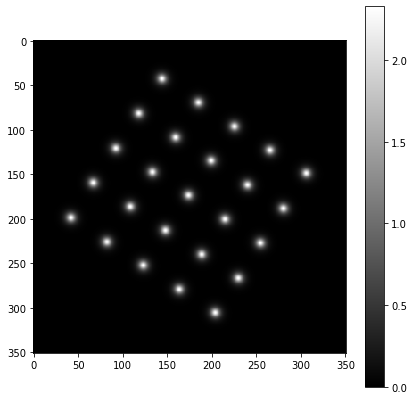

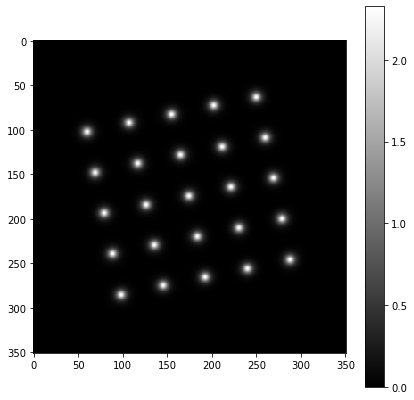

In [70]:
for i in range(n_epoch):
    show_obs_mpl(sim_data['band_data']['i'][i])

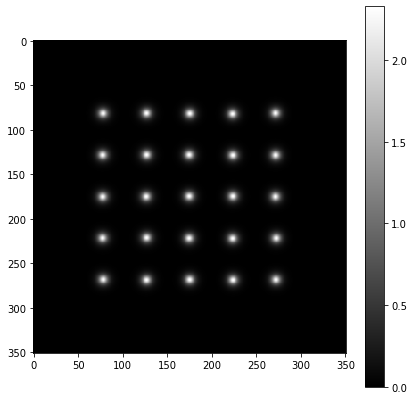

In [71]:
show_obs_mpl(sim_data['coadd_data'])

In [72]:
sim_data["band_data"]["i"][0].variance.array

array([[1.99999996e-14, 1.99999996e-14, 1.99999996e-14, ...,
        1.99999996e-14, 1.99999996e-14, 1.99999996e-14],
       [1.99999996e-14, 1.99999996e-14, 1.99999996e-14, ...,
        1.99999996e-14, 1.99999996e-14, 1.99999996e-14],
       [1.99999996e-14, 1.99999996e-14, 1.99999996e-14, ...,
        1.99999996e-14, 1.99999996e-14, 1.99999996e-14],
       ...,
       [1.99999996e-14, 1.99999996e-14, 1.99999996e-14, ...,
        1.99999996e-14, 1.99999996e-14, 1.99999996e-14],
       [1.99999996e-14, 1.99999996e-14, 1.99999996e-14, ...,
        1.99999996e-14, 1.99999996e-14, 1.99999996e-14],
       [1.99999996e-14, 1.99999996e-14, 1.99999996e-14, ...,
        1.99999996e-14, 1.99999996e-14, 1.99999996e-14]])

## Run SimpleCoadd

In [73]:
from metacoadd.exposure import Exposure, ExpList, CoaddImage
from metacoadd.metacoadd import SimpleCoadd

In [74]:
import galsim
import copy

In [75]:
explist = ExpList()
rng=np.random.RandomState(1234)
for i in range(n_epoch):
    exp = Exposure(
        image=sim_data['band_data']['i'][i].image.array,
        weight=1/sim_data['band_data']['i'][i].variance.array,
        noise=rng.normal(size=sim_data['band_data']['i'][i].image.array.shape)*np.sqrt(sim_data["band_data"]["i"][i].variance.array),
        wcs=copy.deepcopy(sim_data['band_data']['i'][i].wcs),
    )
    explist.append(exp)

In [76]:
sim_data['band_data']['i'][0].wcs

galsim.GSFitsWCS(_data = ['TAN', array([175.0, 175.0]), array([[-4.6450368716994095e-05, -3.0475941316745517e-05], [-3.0475941316745517e-05, 4.6450368716994095e-05]]), coord.CelestialCoord(coord.Angle(3.490658503988659, coord.radians), coord.Angle(0.0, coord.radians)), None, None, None])

In [77]:
sim_data["coadd_wcs"]

galsim.GSFitsWCS(_data = ['TAN', array([175.0, 175.0]), array([[-5.5555555555555565e-05, -0.0], [0.0, 5.5555555555555565e-05]]), coord.CelestialCoord(coord.Angle(3.490658503988659, coord.radians), coord.Angle(0.0, coord.radians)), None, None, None])

In [78]:
explist[0].wcs.astropy

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 200.0  0.0  
CRPIX : 175.0  175.0  
CD1_1 CD1_2  : -4.6450368716994e-05  -3.0475941316745e-05  
CD2_1 CD2_2  : -3.0475941316745e-05  4.64503687169941e-05  
NAXIS : 351  351

In [79]:
coaddimage = CoaddImage(
    explist,
    world_coadd_center=sim_data["coadd_wcs"].center,
    scale=np.abs(sim_data["coadd_wcs"].cd[0,0]*3600),
    image_coadd_size=sim_data["coadd_dims"][0],
    resize_exposure=True,
    relax_resize=0.5,
)
coaddimage.get_all_resamp_images()

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 200.0  0.0  
CRPIX : 175.0  175.0  
PC1_1 PC1_2  : -4.6450368716994e-05  -3.0475941316745e-05  
PC2_1 PC2_2  : -3.0475941316745e-05  4.6450368716994e-05  
CDELT : 1.0  1.0  
NAXIS : 351  351
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 200.0  0.0  
CRPIX : 176.0  176.0  
CD1_1 CD1_2  : -5.5555555555555e-05  -0.0  
CD2_1 CD2_2  : 0.0  5.55555555555555e-05  
NAXIS : 351  351
image
galsim.hsm.ShapeData(image_bounds=galsim.BoundsI(xmin=1, xmax=351, ymin=1, ymax=351), moments_status=0, observed_shape=galsim.Shear((0.01569476545681628-1.1320583453104301e-08j)), moments_sigma=4.147294521331787, moments_amp=219.01406860351562, moments_centroid=galsim.PositionD(x=175.69145522276946, y=175.64599158937733), moments_rho4=2.2198991768217846, moments_n_iter=19, correction_status=-10)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 200.0  0.0  
CRPIX : 175.0  175.0

#### Deal with the PSF

In [80]:
explist_psf = ExpList()
for i in range(n_epoch):
    coadd_center_on_exp = sim_data['band_data']['i'][i].wcs.toImage(
            sim_data["coadd_wcs"].center
        )
    gs_img = sim_data['band_data']['i'][i].psf._get_gspsf(coadd_center_on_exp)
    psf_img_local = gs_img.drawImage(
        center=coadd_center_on_exp,
        nx=sim_data["psf_dims"][0],
        ny=sim_data["psf_dims"][1],
        wcs=copy.deepcopy(sim_data['band_data']['i'][i].wcs),
    )
    psf_weight = np.ones_like(psf_img_local.array) / 1e-5**2
    psf_weight_galsim = galsim.Image(
            psf_weight,
            bounds=psf_img_local.bounds,
        )
    exp_psf = Exposure(
        image=psf_img_local,
        weight=psf_weight_galsim,
        wcs=copy.deepcopy(sim_data['band_data']['i'][i].wcs),
    )
    explist_psf.append(exp_psf)

In [81]:
psf_img_local.bounds

galsim.BoundsI(xmin=150, xmax=200, ymin=150, ymax=200)

In [82]:
sim_data["coadd_wcs"].center.ra.deg, sim_data["coadd_wcs"].center.dec.deg

(200.0, 0.0)

In [83]:
coaddimage_psf = CoaddImage(
    explist_psf,
    world_coadd_center=sim_data["coadd_wcs"].center,
    scale=np.abs(sim_data["coadd_wcs"].cd[0,0]*3600),
    image_coadd_size=sim_data["psf_dims"][0],
    resize_exposure=True,
    relax_resize=0.5
)
coaddimage_psf.get_all_resamp_images()

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 200.0  0.0  
CRPIX : 26.0  26.0  
PC1_1 PC1_2  : -4.6450368716994e-05  -3.0475941316745e-05  
PC2_1 PC2_2  : -3.0475941316745e-05  4.6450368716994e-05  
CDELT : 1.0  1.0  
NAXIS : 51  51
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 200.0  0.0  
CRPIX : 26.0  26.0  
CD1_1 CD1_2  : -5.5555555555555e-05  -0.0  
CD2_1 CD2_2  : 0.0  5.55555555555555e-05  
NAXIS : 51  51
image
galsim.hsm.ShapeData(image_bounds=galsim.BoundsI(xmin=1, xmax=51, ymin=1, ymax=51), moments_status=0, observed_shape=galsim.Shear((-4.0872430440153096e-11-3.0415953637024165e-15j)), moments_sigma=1.7232568264007568, moments_amp=1.0000821352005005, moments_centroid=galsim.PositionD(x=25.999999999999986, y=26.000000000002295), moments_rho4=1.9997997988553213, moments_n_iter=13, correction_status=-10)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 200.0  0.0  
CRPIX : 26.0  26.0  
PC1_

In [84]:
coadd_test = np.nanmean([coaddimage.explist[i].image_resamp.array for i in range(n_epoch)], axis=0)

In [85]:
coaddimage.explist[0].image.array.shape

(351, 351)

In [86]:
coaddimage.coadd_wcs

galsim.GSFitsWCS(_data = ['TAN', array([176.0, 176.0]), array([[-5.5555555555555565e-05, -0.0], [0.0, 5.5555555555555565e-05]]), coord.CelestialCoord(coord.Angle(3.490658503988659, coord.radians), coord.Angle(0.0, coord.radians)), None, None, None])

In [87]:
coaddimage.coadd_wcs.astropy

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 200.0  0.0  
CRPIX : 176.0  176.0  
CD1_1 CD1_2  : -5.5555555555555e-05  -0.0  
CD2_1 CD2_2  : 0.0  5.55555555555555e-05  
NAXIS : 351  351

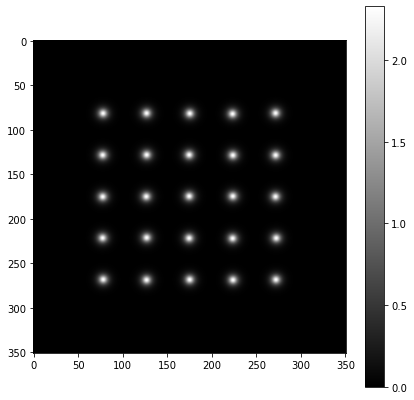

In [88]:
plt.figure(figsize=(7,7))
plt.imshow(coadd_test, cmap='gray')
plt.colorbar()

max ori: 2.3294906616210938
max new: 2.329476566428374
RMSE: 7.855867429865123e-07


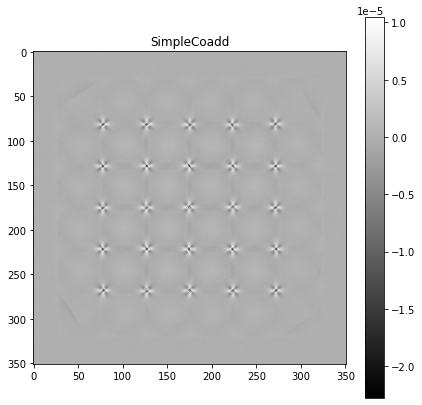

In [89]:
plt.figure(figsize=(7,7))
max_true = np.max(sim_data['coadd_data'].image.array)
max_new = np.nanmax(coadd_test)
plt.imshow(coadd_test-sim_data['coadd_data'].image.array, cmap='gray')
plt.colorbar()
plt.title("SimpleCoadd")
print("max ori:", max_true)
print("max new:", max_new)
print("RMSE:", np.sqrt(np.nanmean((coadd_test-sim_data['coadd_data'].image.array)**2)))

In [90]:
coaddimage.coadd_bounds.shift(galsim.PositionI(-1,-1))

galsim.BoundsI(xmin=0, xmax=350, ymin=0, ymax=350)

In [91]:
coaddimage.coadd_wcs

galsim.GSFitsWCS(_data = ['TAN', array([176.0, 176.0]), array([[-5.5555555555555565e-05, -0.0], [0.0, 5.5555555555555565e-05]]), coord.CelestialCoord(coord.Angle(3.490658503988659, coord.radians), coord.Angle(0.0, coord.radians)), None, None, None])

In [92]:
explist[0].wcs

galsim.GSFitsWCS(_data = ['TAN', array([175.0, 175.0]), array([[-4.6450368716994095e-05, -3.0475941316745517e-05], [-3.0475941316745517e-05, 4.6450368716994095e-05]]), coord.CelestialCoord(coord.Angle(3.490658503988659, coord.radians), coord.Angle(0.0, coord.radians)), None, None, None])

In [93]:
explist[0].wcs.origin

galsim.PositionD(x=0.0, y=0.0)

In [94]:
sim_data['band_data']['i'][0].wcs

galsim.GSFitsWCS(_data = ['TAN', array([175.0, 175.0]), array([[-4.6450368716994095e-05, -3.0475941316745517e-05], [-3.0475941316745517e-05, 4.6450368716994095e-05]]), coord.CelestialCoord(coord.Angle(3.490658503988659, coord.radians), coord.Angle(0.0, coord.radians)), None, None, None])

In [95]:
test = galsim.Image(coadd_dim, coadd_dim, wcs=sim_data['band_data']['i'][0].wcs)

In [96]:
test

galsim.Image(bounds=galsim.BoundsI(xmin=1, xmax=351, ymin=1, ymax=351), array=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32), wcs=galsim.GSFitsWCS(_data = ['TAN', array([175.0, 175.0]), array([[-4.6450368716994095e-05, -3.0475941316745517e-05], [-3.0475941316745517e-05, 4.6450368716994095e-05]]), coord.CelestialCoord(coord.Angle(3.490658503988659, coord.radians), coord.Angle(0.0, coord.radians)), None, None, None]))

In [97]:
test.true_center

galsim.PositionD(x=176.0, y=176.0)

In [98]:
simplecoadd = SimpleCoadd(coaddimage)

In [99]:
simplecoadd.go()

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 200.0  0.0  
CRPIX : 175.0  175.0  
PC1_1 PC1_2  : -4.6450368716994e-05  -3.0475941316745e-05  
PC2_1 PC2_2  : -3.0475941316745e-05  4.6450368716994e-05  
CDELT : 1.0  1.0  
NAXIS : 351  351
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 200.0  0.0  
CRPIX : 176.0  176.0  
CD1_1 CD1_2  : -5.5555555555555e-05  -0.0  
CD2_1 CD2_2  : 0.0  5.55555555555555e-05  
NAXIS : 351  351
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 200.0  0.0  
CRPIX : 175.0  175.0  
PC1_1 PC1_2  : 5.4405419302381e-05  -1.1245892744399e-05  
PC2_1 PC2_2  : -1.1245892744399e-05  -5.440541930238e-05  
CDELT : 1.0  1.0  
NAXIS : 351  351
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 200.0  0.0  
CRPIX : 176.0  176.0  
CD1_1 CD1_2  : -5.5555555555555e-05  -0.0  
CD2_1 CD2_2  : 0.0  5.55555555555555e-05  
NAXIS : 351  351


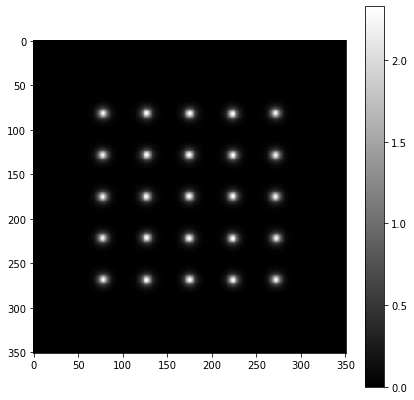

In [100]:
show_obs_mpl(simplecoadd.coaddimage)

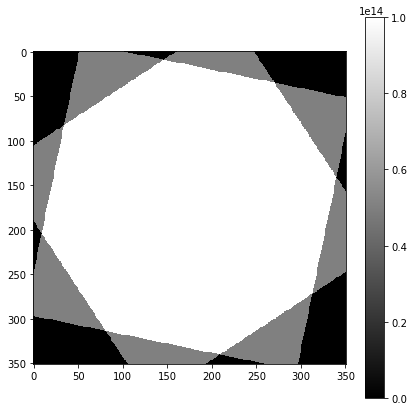

In [101]:
plt.figure(figsize=(7,7))
plt.imshow(simplecoadd.coaddimage.weight.array, cmap='gray', interpolation='nearest')
plt.colorbar()

max ori: 2.3294906616210938
max new: 2.3294766
RMSE: 7.983225853270926e-07


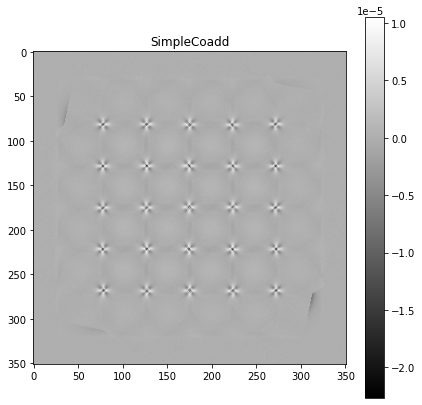

In [102]:
plt.figure(figsize=(7,7))
max_true = np.max(sim_data['coadd_data'].image.array)
max_new = np.nanmax(simplecoadd.coaddimage.image.array)
plt.imshow(simplecoadd.coaddimage.image.array-sim_data['coadd_data'].image.array, cmap='gray')
plt.colorbar()
plt.title("SimpleCoadd")
print("max ori:", max_true)
print("max new:", max_new)
print("RMSE:", np.sqrt(np.nanmean((simplecoadd.coaddimage.image.array-sim_data['coadd_data'].image.array)**2)))

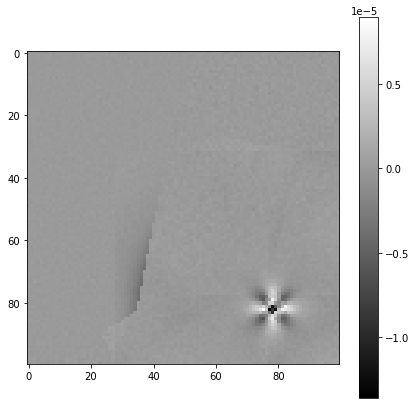

In [103]:
plt.figure(figsize=(7,7))
diff = simplecoadd.coaddimage.image.array-sim_data['coadd_data'].image.array
plt.imshow(diff[0:100,0:100], cmap='gray', interpolation='nearest')
plt.colorbar()

In [104]:
simplecoadd_psf = SimpleCoadd(coaddimage_psf, do_border=False)
simplecoadd_psf.go()

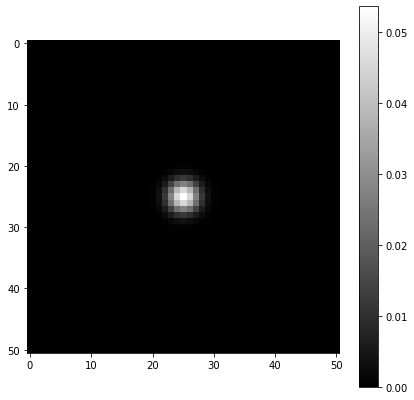

In [105]:
show_obs_mpl(simplecoadd_psf.coaddimage)

In [106]:
psf_center = 25
off=-1
perfect_psf = sim_data["coadd_data"].psf.drawImage(
    center=galsim.PositionD(psf_center,psf_center),
    offset=galsim.PositionD(off,off),
    nx=51,
    ny=51,
    wcs=sim_data["coadd_wcs"].local(galsim.PositionD(psf_center,psf_center)),
)
perfect_psf.setOrigin(1,1)

In [107]:
perfect_psf

galsim.Image(bounds=galsim.BoundsI(xmin=1, xmax=51, ymin=1, ymax=51), array=
array([[ 6.0741834e-10, -9.2574197e-09, -2.1120272e-09, ...,
         4.4437559e-10,  1.5365851e-09, -8.2612877e-09],
       [-9.3044141e-09, -2.3753988e-09,  4.9960573e-09, ...,
        -9.4464285e-09,  5.2731717e-09, -3.1533529e-09],
       [-2.1943263e-09,  4.9548610e-09, -7.8223312e-09, ...,
        -2.2771129e-09, -7.8844966e-09,  8.3404267e-10],
       ...,
       [ 5.4660909e-10, -9.3406349e-09, -2.1945823e-09, ...,
         4.6364107e-10,  1.5578401e-09, -8.2339842e-09],
       [ 1.6015456e-09,  5.3513491e-09, -7.8182048e-09, ...,
         1.5196395e-09, -9.2873309e-09,  1.0589517e-09],
       [-8.2567118e-09, -3.1281413e-09,  8.5752971e-10, ...,
        -8.2789393e-09,  1.0419600e-09,  4.5679842e-09]], dtype=float32), wcs=galsim.AffineTransform(0.19999999365380397, -6.617444970416893e-25, -4.2307972732920386e-09, 0.19999999365380408, origin=galsim.PositionI(x=1, y=1), world_origin=galsim.PositionD(x=0

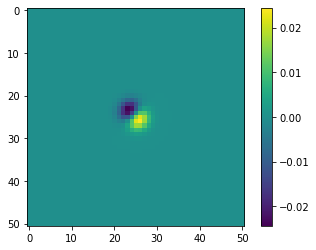

In [108]:
plt.imshow(simplecoadd_psf.coaddimage.image.array-perfect_psf.array)
plt.colorbar()

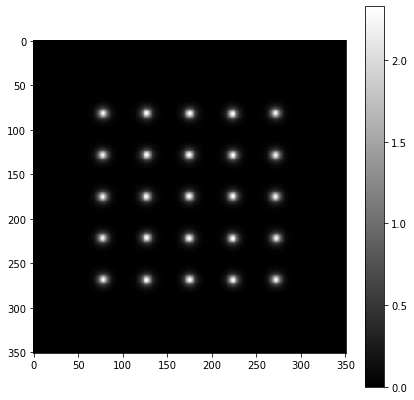

In [109]:
show_obs_mpl(simplecoadd.coaddimage)

In [110]:
from metacoadd.simu import run_metadetect, get_shear

In [111]:
from metacoadd.simu.simu import run_metadetect_perfect

In [112]:
import metacoadd.simu.simu as sim

In [113]:
res = run_metadetect(simplecoadd, simplecoadd_psf, 1234)
res_shear = get_shear(res)
print(res_shear)

[(0.00722742, -1.16671863e-08, 0.36130676, 0.36151001)]


In [114]:
print("m (1e-3):", np.abs((0.02-res_shear['g1']/res_shear["R11"])/0.02)[0]/1e-3)
print("c (1e-4):", np.abs(res_shear['g2']/res_shear["R22"])[0]/1e-4)

m (1e-3): 0.17808338394712658
c (1e-4): 0.00032273480502641074


In [115]:
res_perfect = run_metadetect_perfect(sim_data["coadd_data"], 0.2, 1234)
res_shear_perfect = get_shear(res_perfect)
print(res_shear_perfect)

[(0.00722744, -1.51768766e-08, 0.36130621, 0.36150975)]


In [116]:
print("m (1e-3):", np.abs((0.02-res_shear_perfect['g1']/res_shear_perfect["R11"])/0.02)[0]/1e-3)
print("c (1e-4):", np.abs(res_shear_perfect['g2']/res_shear_perfect["R22"])[0]/1e-4)

m (1e-3): 0.18260321409391267
c (1e-4): 0.00041981929201133654


## Compare

In [117]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Input exp - true coadd')

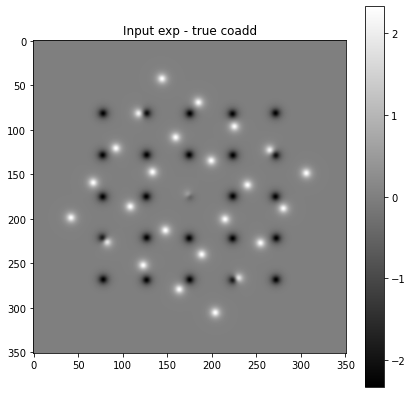

In [118]:
plt.figure(figsize=(7,7))
plt.imshow(sim_data['band_data']['i'][0].image.array-sim_data['coadd_data'].image.array, cmap='gray')
plt.colorbar()
plt.title("Input exp - true coadd")

Text(0.5, 1.0, 'Input exp - true coadd')

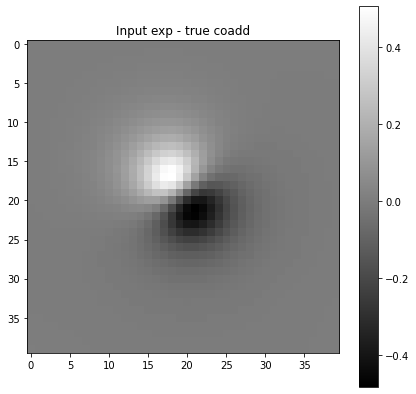

In [119]:
plt.figure(figsize=(7,7))
diff = sim_data['band_data']['i'][0].image.array-sim_data['coadd_data'].image.array
plt.imshow(diff[155:195,155:195], cmap='gray')
plt.colorbar()
plt.title("Input exp - true coadd")

max ori: 2.3294906616210938
max new: 2.3294766


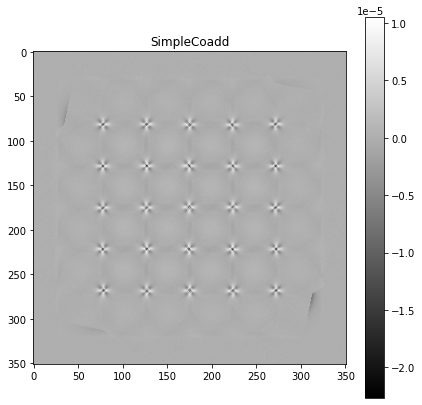

In [120]:
plt.figure(figsize=(7,7))
max_true = np.max(sim_data['coadd_data'].image.array)
max_new = np.max(simplecoadd.coaddimage.image.array)
plt.imshow(simplecoadd.coaddimage.image.array-sim_data['coadd_data'].image.array, cmap='gray')
plt.colorbar()
plt.title("SimpleCoadd")
print("max ori:", max_true)
print("max new:", max_new)

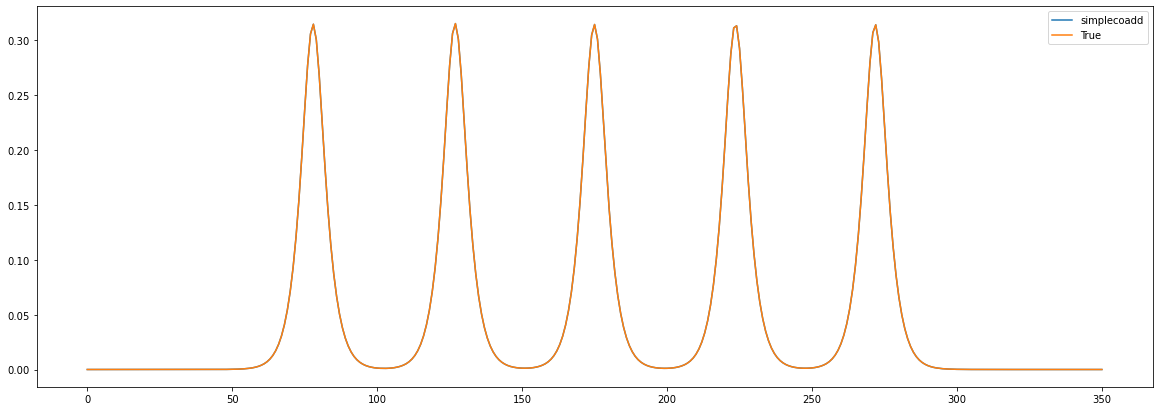

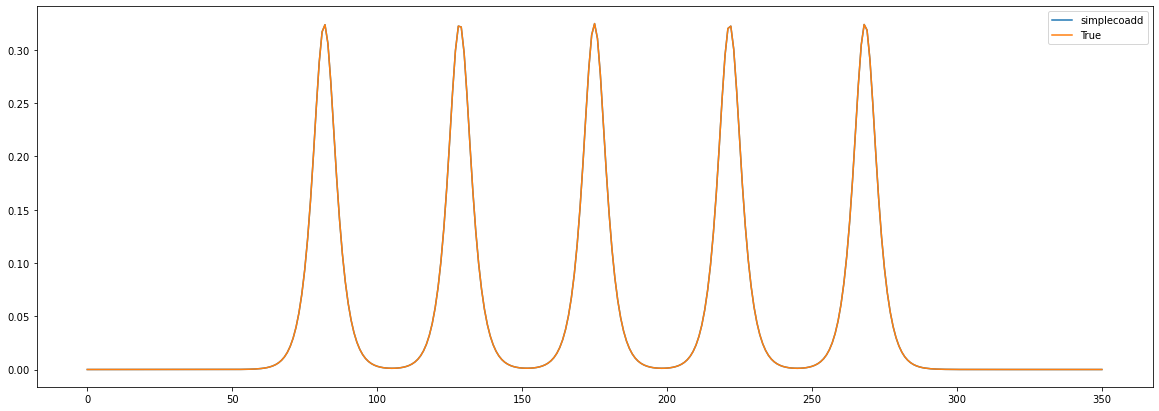

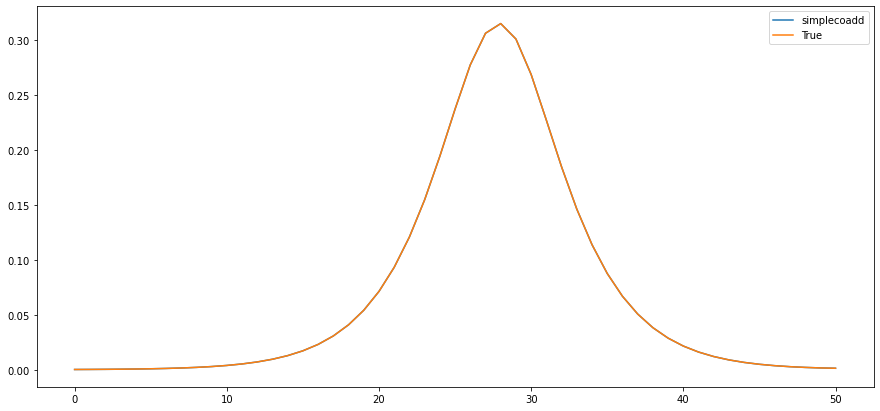

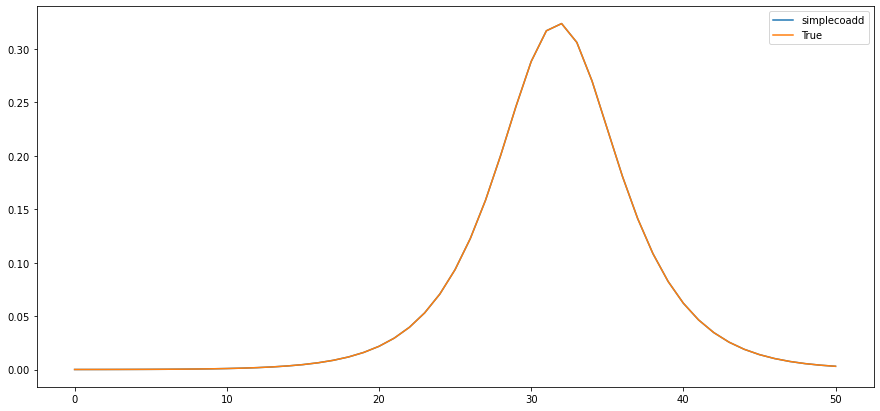

In [121]:
plt.figure(figsize=(20, 7))
plt.plot(np.mean(simplecoadd.coaddimage.image.array, 0), label='simplecoadd')
plt.plot(np.mean(sim_data['coadd_data'].image.array, 0), label='True')
plt.legend()
plt.figure(figsize=(20, 7))
plt.plot(np.mean(simplecoadd.coaddimage.image.array, 1), label='simplecoadd')
plt.plot(np.mean(sim_data['coadd_data'].image.array, 1), label='True')
plt.legend()
plt.figure(figsize=(15, 7))
x = np.arange(50, 101)-50
plt.plot(x, np.mean(simplecoadd.coaddimage.image.array, 0)[50:101], label='simplecoadd')
plt.plot(np.mean(sim_data['coadd_data'].image.array, 0)[50:101], label='True')
plt.legend()
plt.figure(figsize=(15, 7))
x = np.arange(50, 101)-50
plt.plot(x, np.mean(simplecoadd.coaddimage.image.array, 1)[50:101], label='simplecoadd')
plt.plot(np.mean(sim_data['coadd_data'].image.array, 1)[50:101], label='True')
plt.legend()

max ori: 2.3296942710876465
max new: 2.3294766


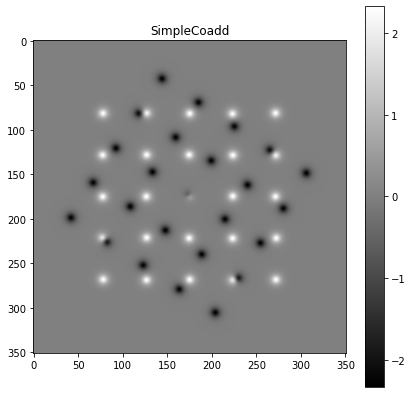

In [122]:
plt.figure(figsize=(7,7))
max_true = np.max(sim_data['band_data']['i'][0].image.array)
max_new = np.max(simplecoadd.coaddimage.image.array)
plt.imshow(simplecoadd.coaddimage.image.array-sim_data['band_data']['i'][0].image.array, cmap='gray')
plt.colorbar()
plt.title("SimpleCoadd")
print("max ori:", max_true)
print("max new:", max_new)

In [123]:
def get_shape(image):
    gal_image = galsim.Image(image)
    s = galsim.hsm.FindAdaptiveMom(gal_image, strict=False)
    if s.error_message == '':
        print("g1:", s.observed_shape.g1, "g2:", s.observed_shape.g2)
    else:
        print("Error")
def get_shape_err(image, image_ref):
    gal_image = galsim.Image(image)
    s = galsim.hsm.FindAdaptiveMom(gal_image, strict=False)
    
    # Ref
    gal_image_ref = galsim.Image(image_ref)
    s_ref = galsim.hsm.FindAdaptiveMom(gal_image_ref, strict=False)
    if (s.error_message == '') and (s_ref.error_message == ''):
        print(
            "m (1e-3):", np.abs((s.observed_shape.g1-s_ref.observed_shape.g1)/s_ref.observed_shape.g1)/1e-3,
            "\nc (1e-4):", s.observed_shape.g2/1e-4,
        )
    else:
        print("Error")

In [124]:
for i in range(n_epoch):
    get_shape(sim_data['band_data']['i'][i].image.array)

g1: 0.006248828809525905 g2: 0.014397130305726327
g1: 0.014408518544695674 g2: -0.006222614012077187


In [125]:
get_shape(sim_data['coadd_data'].image.array)
get_shape_err(sim_data['coadd_data'].image.array, sim_data['band_data']['i'][0].image.array)

g1: 0.01569479155312518 g2: -8.79056238029412e-08
m (1e-3): 1511.6373054098651 
c (1e-4): -0.000879056238029412


In [126]:
get_shape(simplecoadd.coaddimage.image.array)

g1: 0.015694769184860454 g2: -6.650790197467576e-08


In [127]:
get_shape_err(simplecoadd.coaddimage.image.array, sim_data['coadd_data'].image.array)

m (1e-3): 0.0014252030459184285 
c (1e-4): -0.0006650790197467576


## Astropy reproject

In [128]:
from reproject import reproject_exact, reproject_adaptive, reproject_interp
from reproject.mosaicking import reproject_and_coadd
from astropy.io import fits
from time import time

In [129]:
all_exp = [sim_data['band_data']['i'][i].image.array for i in range(n_epoch)]
all_wcs = [sim_data['band_data']['i'][i].Wcs for i in range(n_epoch)]
all_headers = []
for i in range(n_epoch):
    hdu_tmp = fits.ImageHDU(all_exp[i])
    h_tmp = hdu_tmp.header
    all_wcs[i].writeToFitsHeader(h_tmp, galsim.Image(all_exp[i]).bounds)
    all_headers.append(h_tmp)
input_coadd = [(all_exp[i], all_headers[i]) for i in range(n_epoch)]

AttributeError: 'ExposureF' object has no attribute 'Wcs'

In [130]:
coadd_hdu=fits.ImageHDU(sim_data["coadd_data"].image.array)
h_coadd = coadd_hdu.header
sim_data["coadd_wcs"].writeToFitsHeader(h_coadd, galsim.Image(sim_data["coadd_data"].image.array).bounds)

In [131]:
#reproj_coadd, _ = reproject_interp((all_exp[0], all_headers[0]), h_coadd, (coadd_dim, coadd_dim), order=2)

In [132]:
ts = time()
reproj_coadd, _ = reproject_and_coadd(input_coadd, h_coadd, (coadd_dim, coadd_dim), reproject_function=reproject_interp, combine_function='mean', order=5)
print("total time:", (time() - ts))
print("per epoch time:", (time() - ts)/n_epoch)

NameError: name 'input_coadd' is not defined

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(reproj_coadd, cmap='gray')

In [ ]:
plt.figure(figsize=(7,7))
max_true = np.max(sim_data['coadd_data'].image.array)
max_new = np.nanmax(reproj_coadd)
plt.imshow(reproj_coadd-sim_data['coadd_data'].image.array, cmap='gray')
plt.colorbar()
plt.title("Reproject")
print("max ori:", max_true)
print("max new:", max_new)
print("RMSE:", np.sqrt(np.nanmean((reproj_coadd-sim_data['coadd_data'].image.array)**2)))

In [ ]:
get_shape(sim_data['coadd_data'].image.array)

In [ ]:
get_shape(reproj_coadd)

In [ ]:
get_shape_err(reproj_coadd, sim_data['coadd_data'].image.array)

In [ ]:
import reproject
from astropy.wcs import WCS 

In [ ]:
shape_out = (coadd_dim, coadd_dim)
pixel_out = np.meshgrid(*[np.arange(size, dtype=float) for size in shape_out],
                            indexing='ij', sparse=False, copy=False)
pixel_out = [p.ravel() for p in pixel_out]
reproject.wcs_utils.efficient_pixel_to_pixel_with_roundtrip(WCS(all_headers[0]), WCS(h_coadd), *pixel_out[::-1])

In [ ]:
all_exp = [coaddimage.explist[i].image.array for i in range(n_epoch)]
all_wcs = [coaddimage.explist[i].wcs.astropy for i in range(n_epoch)]
all_headers = []
#for i in range(n_epoch):
#    hdu_tmp = fits.ImageHDU(all_exp[i])
#    h_tmp = hdu_tmp.header
#    all_wcs[i].writeToFitsHeader(h_tmp, galsim.Image(all_exp[i]).bounds)
#    all_headers.append(h_tmp)
input_coadd = [(all_exp[i], all_wcs[i]) for i in range(n_epoch)]

In [ ]:
ts = time()
reproj_coadd, _ = reproject_and_coadd(input_coadd, h_coadd, (coadd_dim, coadd_dim), reproject_function=reproject_interp, combine_function='mean', order=5)
print("total time:", (time() - ts))
print("per epoch time:", (time() - ts)/n_epoch)

In [ ]:
plt.figure(figsize=(7,7))
max_true = np.max(sim_data['coadd_data'].image.array)
max_new = np.nanmax(reproj_coadd)
plt.imshow(reproj_coadd-sim_data['coadd_data'].image.array, cmap='gray')
plt.colorbar()
plt.title("Reproject")
print("max ori:", max_true)
print("max new:", max_new)
print("RMSE:", np.sqrt(np.nanmean((reproj_coadd-sim_data['coadd_data'].image.array)**2)))

In [ ]:
get_shape_err(reproj_coadd, sim_data['coadd_data'].image.array)

In [ ]:
all_exp = [coaddimage.explist[i].weight.array for i in range(n_epoch)]
all_wcs = [coaddimage.explist[i].wcs.astropy for i in range(n_epoch)]
all_headers = []
#for i in range(n_epoch):
#    hdu_tmp = fits.ImageHDU(all_exp[i])
#    h_tmp = hdu_tmp.header
#    all_wcs[i].writeToFitsHeader(h_tmp, galsim.Image(all_exp[i]).bounds)
#    all_headers.append(h_tmp)
input_coadd = [(all_exp[i], all_wcs[i]) for i in range(n_epoch)]

In [ ]:
ts = time()
reproj_coadd, _ = reproject_and_coadd(input_coadd, h_coadd, (coadd_dim, coadd_dim), reproject_function=reproject_interp, combine_function='mean', order=5)
print("total time:", (time() - ts))
print("per epoch time:", (time() - ts)/n_epoch)

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(reproj_coadd, cmap='gray')
plt.colorbar()

In [ ]:
reproj_coadd[np.isfinite(reproj_coadd)][np.where(reproj_coadd[np.isfinite(reproj_coadd)] != 1.)]

## Test Matt code

In [ ]:
from numba import njit
import math

In [ ]:
@njit(fastmath=True)
def sinc(x):
    if abs(x) < 1e-4:
        return 1 - (math.pi * math.pi / 6) * x * x
    else:
        ax = math.pi * x
        return np.sin(ax) / ax
    
@njit(fastmath=True)
def lanczos_resample_one(im1, rows, cols):
    """Lanczos resample one image at the input row and column positions.
    Points whose interpolation kernel would be truncated because it extends
    beyond the input image are marked with edge=True in the output
    edge boolean array
    Parameters
    ----------
    im1 : np.ndarray
        A two-dimensional array with the image values.
    rows : np.ndarray
        A one-dimensional array of input row/y values. These denote the
        location to sample on the first, slowest moving axis of the image.
    cols : np.ndarray
        A one-dimensional array of input column/x values. These denote the
        location to sample on the second, fastest moving axis of the image.
    Returns
    -------
    values1, edge : np.ndarray
        The resampled value for each row, column pair. Points whose
        interpolation kernal was truncated because it extended beyond
        the input image have edge=True
    """
    a = 3
    ny, nx = im1.shape
    outsize = rows.shape[0]

    res1 = np.zeros(outsize, dtype=np.float64)
    edge = np.zeros(outsize, dtype=np.bool_)

    for i in range(rows.shape[0]):
        y = rows[i]
        x = cols[i]

        # get range for kernel
        x_s = int(np.floor(x)) - a + 1
        x_f = int(np.floor(x)) + a
        y_s = int(np.floor(y)) - a + 1
        y_f = int(np.floor(y)) + a

        out_of_bounds = (
            x_f < 0 or
            x_s > nx-1 or
            y_f < 0 or
            y_s > ny-1
        )

        if out_of_bounds:
            edge[i] = True

        # now sum over the cells in the kernel
        val1 = 0.0
        for y_pix in range(y_s, y_f+1):
            if y_pix < 0 or y_pix > ny-1:
                continue

            dy = y - y_pix
            sy = sinc(dy) * sinc(dy/a)

            for x_pix in range(x_s, x_f+1):
                if x_pix < 0 or x_pix > nx-1:
                    continue

                dx = x - x_pix
                sx = sinc(dx) * sinc(dx/a)

                kernel = sx*sy

                val1 += im1[y_pix, x_pix] * kernel

        res1[i] = val1

    return res1, edge

In [ ]:
def coadd_image_noise_interpfrac(
        se_images, all_headers,
        h_coadd,
        coadd_scale, coadd_dim):
    """Coadd a set of SE images, noise fields, and interpolation fractions.
    Parameters
    ----------
    se_images : list of np.ndarray
        The list of SE images to coadd.
    se_noises : list of np.ndarray
        The list of SE noise images to coadd.
    se_interp_fracs : list of np.ndarray
        The list of SE interpolated fraction images to coadd.
    se_wcs_objs : list of galsim.BaseWCS or children
        The WCS objects for each of the SE images.
    coadd_wgts : 1d array-like object of floats
        The relative coaddng weights for each of the SE images.
    coadd_scale : float
        The pixel scale of desired coadded image.
    coadd_dim : int
        The number of pixels desired for the final coadd image..
    Returns
    -------
    img : np.ndarray, shape (coadd_dim, coadd_dim)
        The coadd image.
    nse : np.ndarray, shape (coadd_dim, coadd_dim)
        The coadd noise image.
    intp : np.ndarray, shape (coadd_dim, coadd_dim)
        The interpolated flux fraction in each coadd pixel.
    """

    # coadd pixel coords
    shape_out = (coadd_dim, coadd_dim)
    pixel_out = np.meshgrid(*[np.arange(size, dtype=float) for size in shape_out],
                            indexing='ij', sparse=False, copy=False)
    pixel_out = [p.ravel() for p in pixel_out]

    coadd_image = np.zeros(shape_out, dtype=np.float64)

    wgt = 1 #coadd_wgts / np.sum(coadd_wgts)

    for se_im, se_h in zip(
            se_images, all_headers):

        #se_x, se_y = se_wcs.toImage(u, v, units=galsim.degrees)
        #se_x, se_y = [se_wcs.toImage(galsim.CelestialCoord(ra=uu, dec=vv)) for uu, vv in zip(u,v)]
        se_x, se_y = reproject.wcs_utils.efficient_pixel_to_pixel_with_roundtrip(WCS(se_h), WCS(h_coadd), *pixel_out[::-1])
        im, _ = lanczos_resample_one(
            se_im / 0.2**2,#se_wcs.pixelArea(image_pos=galsim.PositionD(0,0)),
            se_x,
            se_y)

        coadd_image += (im.reshape((coadd_dim, coadd_dim)) * wgt)

    #coadd_image *= ((coadd_scale/galsim.arcsec)**2)
    coadd_image *= 0.2**2
    coadd_image /= len(se_im)

    return coadd_image

In [ ]:
all_exp = [sim_data['band_data']['i'][i].image.array for i in range(n_epoch)]
all_wcs = [sim_data['band_data']['i'][i].Wcs for i in range(n_epoch)]

In [ ]:
matt_coadd = coadd_image_noise_interpfrac(
    all_exp,
    all_headers,
    h_coadd,
    0.2*galsim.arcsec,
    coadd_dim
)

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(matt_coadd, cmap='gray')
plt.colorbar()

In [ ]:
plt.figure(figsize=(7,7))
max_true = np.max(sim_data['coadd_data'].image.array)
max_new = np.nanmax(matt_coadd)
plt.imshow(matt_coadd/max_new-sim_data['coadd_data'].image.array/max_true, cmap='gray')
plt.colorbar()
plt.title("SimpleCoadd")
print("max ori:", max_true)
print("max new:", max_new)

In [ ]:
plt.figure(figsize=(7,7))
max_true = np.max(simplecoadd.coaddimage.image.array)
max_new = np.nanmax(matt_coadd)
plt.imshow(matt_coadd/max_new-simplecoadd.coaddimage.image.array/max_true, cmap='gray')
plt.colorbar()
plt.title("SimpleCoadd")
print("max ori:", max_true)
print("max new:", max_new)

In [ ]:
get_shape(matt_coadd)

In [ ]:
get_shape_err(matt_coadd, sim_data['coadd_data'].image.array)

## Test Astropy DRIZZLE

In [ ]:
from drizzle.drizzle import Drizzle

In [ ]:
Drizzle?

In [ ]:
#reflist = fits.open(reference)
#reference_wcs = wcs.WCS(reflist[1].header)

# Initialize the output with the WCS
ts = time()
driz = Drizzle(outwcs=WCS(h_coadd), pixfrac=1.0, wt_scl="", kernel="lanczos3")

# Combine the input images into on drizzle image
for se_im, se_h in zip(
            all_exp, all_headers):
    # Open the file and read the image and wcs
    # This is a contrived example, we would not do this
    # unless the data came from another source
    # than a FITS file
    driz.add_image(se_im, WCS(se_h))

# Write the drizzled image out
#driz.write(outfile)
driz_coadd = driz.outsci
t_end = time()
print("total time:", (t_end - ts))
print("per epoch time:", (t_end - ts)/n_epoch)

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(driz_coadd, cmap='gray')

In [ ]:
plt.figure(figsize=(7,7))
max_true = np.max(sim_data['coadd_data'].image.array)
max_new = np.nanmax(reproj_coadd)
plt.imshow(driz_coadd-sim_data['coadd_data'].image.array, cmap='gray')
plt.colorbar()
plt.title("Reproject")
print("max ori:", max_true)
print("max new:", max_new)
print("RMSE:", np.sqrt(np.nanmean((driz_coadd-sim_data['coadd_data'].image.array)**2)))

In [ ]:
get_shape(sim_data['coadd_data'].image.array)

In [ ]:
get_shape(driz_coadd)

In [ ]:
get_shape_err(driz_coadd, sim_data['coadd_data'].image.array)

In [ ]:
a = None

In [ ]:
isinstance(a, type(None))

In [ ]:
w_gal = galsim.AstropyWCS(header=h_coadd)

In [ ]:
w_gal.astropy = w

In [ ]:
w_gal2 = galsim.AstropyWCS(wcs=w_coadd)

In [ ]:
w_gal.toWorld(galsim.PositionD(0,0))

In [ ]:
w_gal2.toWorld(galsim.PositionD(0,0))

In [ ]:
w_gal.writeToFitsHeader?

In [ ]:
sim_data["coadd_wcs"].writeToFitsHeader()

In [ ]:
galsim.Image(galsim.BoundsI(1,10,1,10))

In [ ]:
coaddimage.image_coadd_size